# Predict Chronic Kidney Disease within 3 years of T2D

## Introduction - Problem Statement

Type2Diabetes(T2D) is a chronic condition and leads to several comorbidities. Chronic Kidney Disease among Type2Diabetes patients is one of the fastest growing epidemics. In this notebook we will build a machine learning model that will classify patients who undergo it

<h3>A brief on Dataset and Cohort types:</h3>

The dataset hosts a population fully diagnosed with T2D apart from other conditions. The KD patients can be classified into 3 cohort types:

1)	KD onset before T2D onset

2)	KD onset after T2D onset outside 3 years period

3)	KD onset after T2D onset within 3 years period

Among the above mentioned cohorts, the group which we are interested to predict are of type - 3 (KD onset after T2D onset within 3 years period)

<h3>Type of Features considered:</h3>

1)	Demographics - It contains patient level demographic data such as Age, Race and Gender etc

2)	Diagnosis - It contains data about the several conditions the patient has been diagnosed with

3)	Observations - It contains lab measurement details of the patients

4)	Prescriptions - It contains drug details administered to the patients

<h4>Import Packages</h4>

In [19]:
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix,roc_auc_score, recall_score, precision_score, accuracy_score
from sklearn.preprocessing import label_binarize,StandardScaler
import pickle
import os
from smart_open import smart_open
import seaborn as se

Data Preprocessing is done by using Modularization module 1 and stored it in S3 bucket

In [2]:
%%time
bucket = 'bucket-name'
object_key_data = 'folder-path/common_features_i6mi.csv'
path_data = 'S3://{}:{}@{}/{}'.format('XXXXXXXXXXXXXXXX', 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX', bucket, object_key_data)
data = pd.read_csv(smart_open(path_data))
print("Shape of the dataset ",data.shape)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Shape of the dataset  (328021, 101)
CPU times: user 5.77 s, sys: 1.26 s, total: 7.03 s
Wall time: 7.19 s


<h4>Feature Selection</h4>

In this usecase, feature selection is performed using LightGBM. It is a gradient boosting framework that uses tree based learning algorithm and it grows tree vertically.

Create LGBM feature and its Label

In [3]:
# Dropping unused columns from the feature matrix
col_to_drop = ['person_id', 'kdflag']
lgbm_features = data.drop(col_to_drop,axis=1)
lgbm_labels = data['kdflag']

The parameters tweaked are<br>
<li><b>max_depth</b>- 15, Lower max depth taken to handle model overfitting</li>
<li><b>learning_rate</b> - 0.001, Small learning rate considered for better accuracy</li>
<li><b>num_leaves</b>    - 900, To deal with overfitting</li>

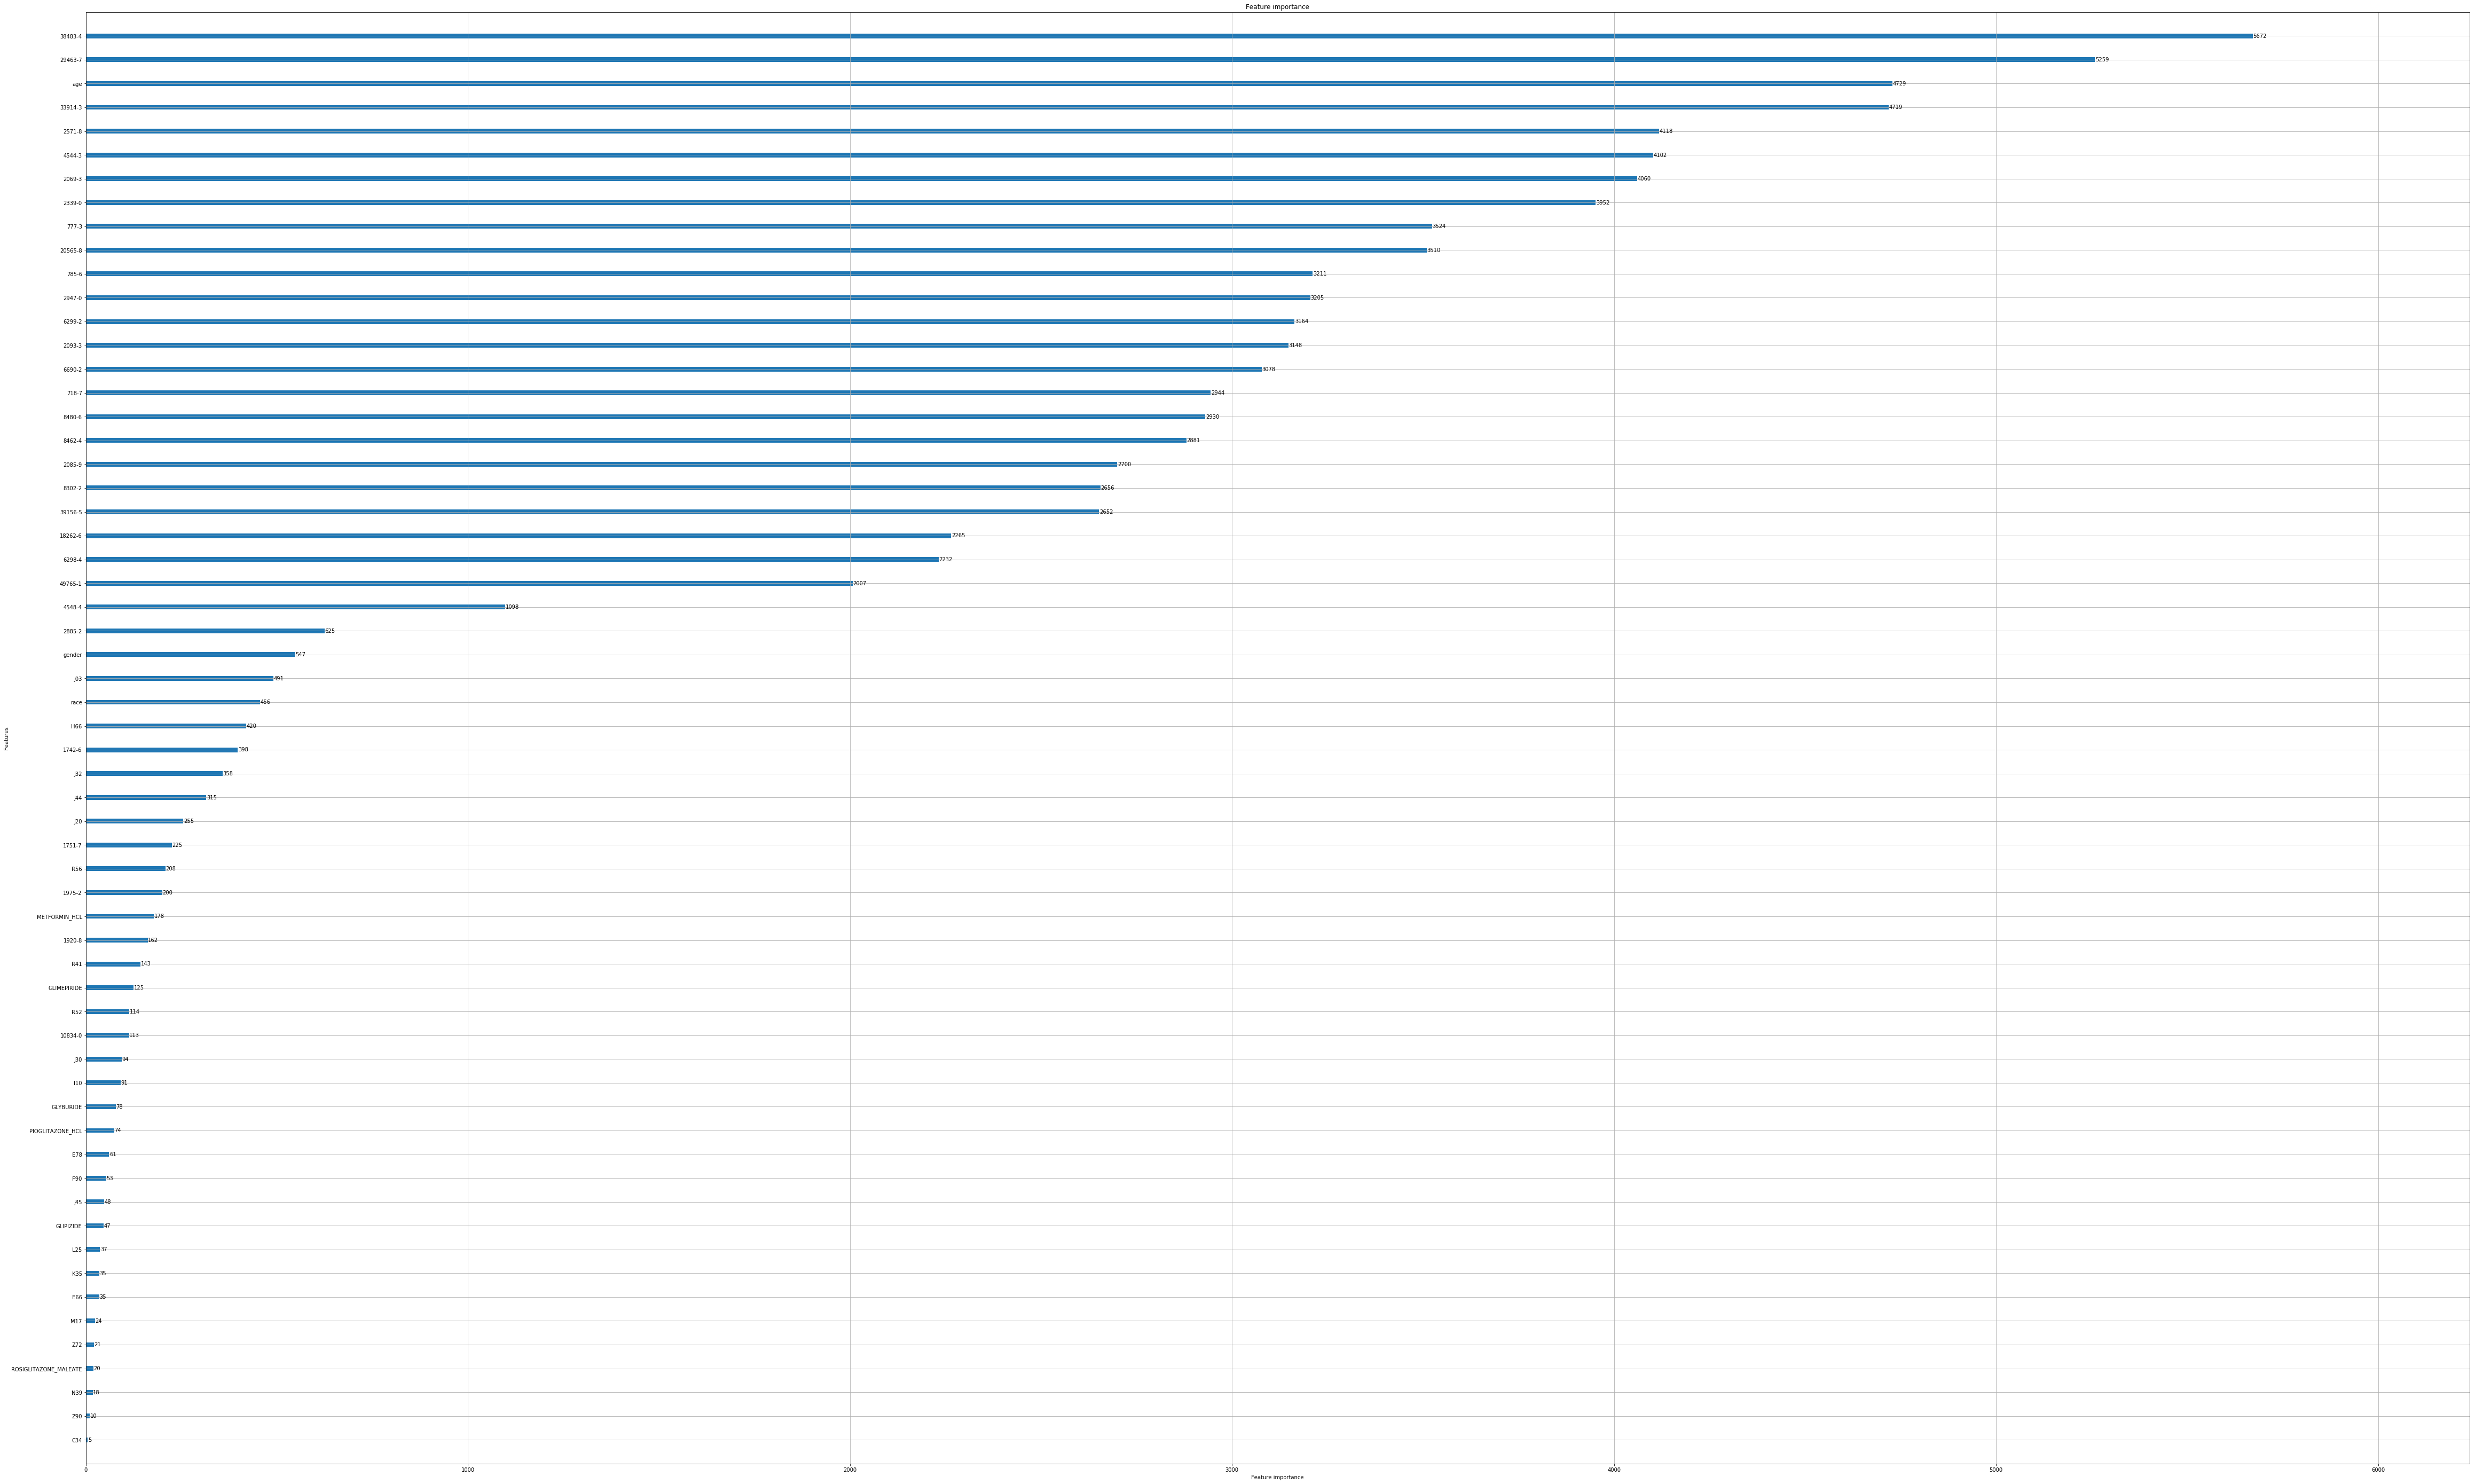

In [4]:
lgbm_data = lgb.Dataset(lgbm_features,label=lgbm_labels)
params = {"max_depth":15, "learning_rate":0.001, "num_leaves":900}
lgm_model = lgb.train(params=params,train_set=lgbm_data,categorical_feature='auto')
lgm_plot = lgb.plot_importance(lgm_model,max_num_features=99,figsize=(80,50))

Retriving features which has high feature importance score and rename columns which are having spaces in names

In [10]:
#Renaming the features to remove spaces inbetween 
lgbm_features = lgbm_features.rename(columns={'METFORMIN HCL':'METFORMIN_HCL','PIOGLITAZONE HCL':'PIOGLITAZONE_HCL','ROSIGLITAZONE MALEATE':'ROSIGLITAZONE_MALEATE'})

#Retriving features which has high feature importance score
this = list(lgm_model.feature_importance())
effe_cols = []
for i in this:
    if i > 3211:
        effe_cols.append(lgm_model.feature_name()[this.index(i)])
        this[this.index(i)]=0
        
effe_cols.extend(['gender','race'])
model_data = lgbm_features[effe_cols]
model_data['kdflag'] = lgbm_labels
model_data = model_data[['age','gender','race','20565-8','2069-3','2339-0','2571-8','29463-7','33914-3','38483-4','4544-3','777-3','kdflag']]

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Based on the Feature importance score and after performing several iterations the final dataframe in which machine learning models are applied have top 10 features and the feature importance score considered is 3211 and above. Column description are given below.

<h4>Data Analysis</h4>

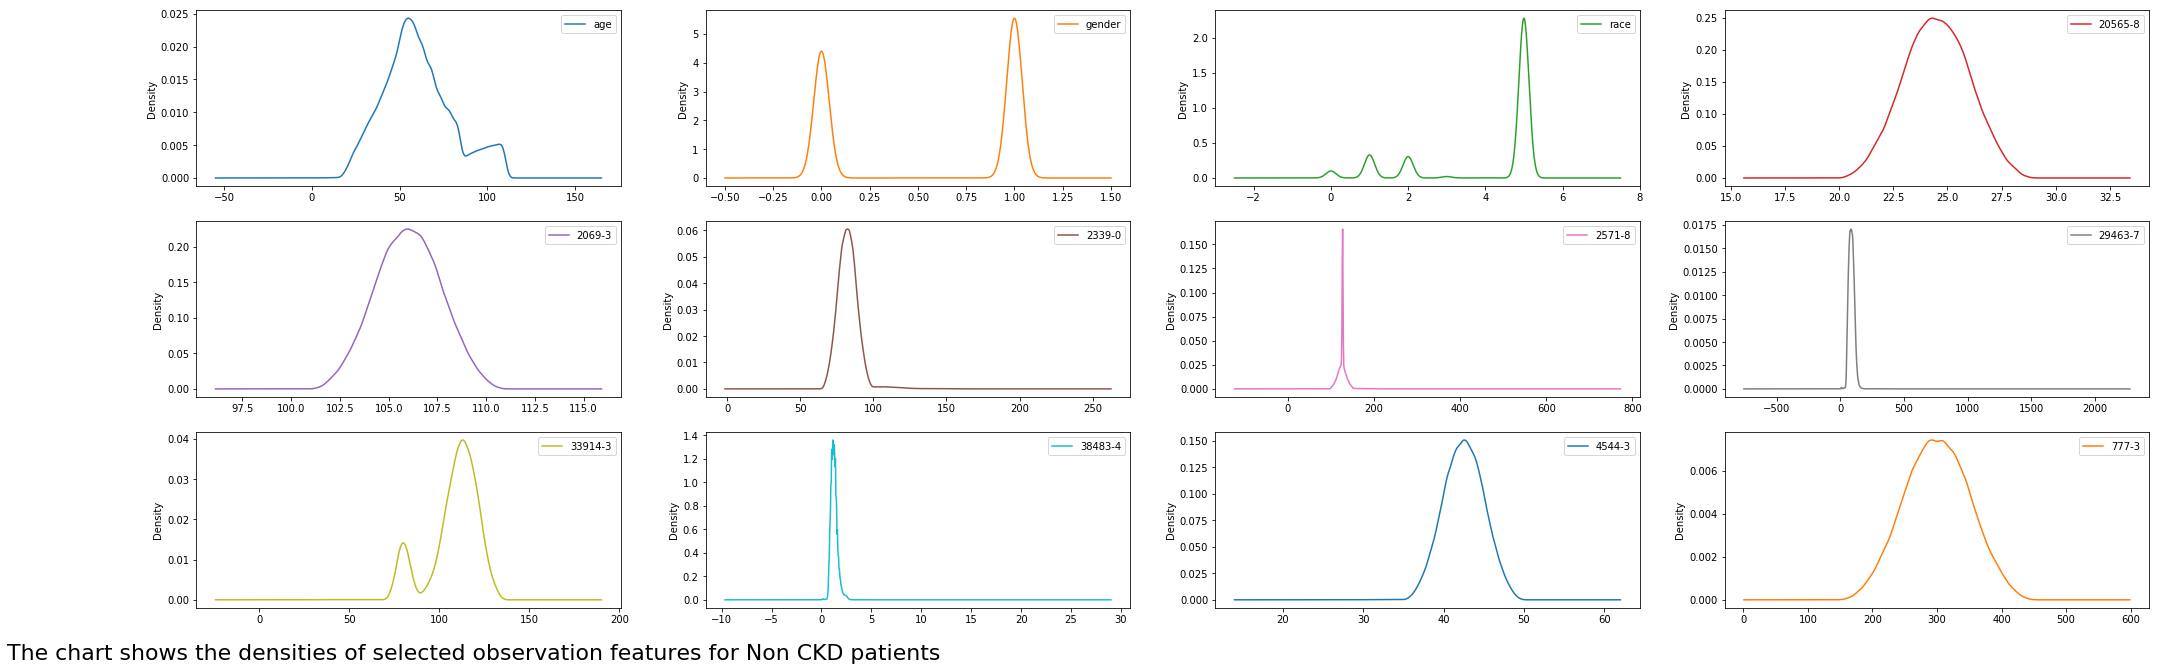

In [12]:
final_data0 = model_data[model_data['kdflag']==0][['age','gender','race','20565-8','2069-3','2339-0','2571-8','29463-7','33914-3','38483-4','4544-3','777-3']]
final_data0.plot(kind='density', subplots=True, layout=(3,4), sharex=False,figsize=(35,10))
plt.subplots_adjust(bottom=0.05)
text="The chart shows the densities of selected observation features for Non CKD patients"
plt.figtext(0.05,0.00, text, fontsize=22, va="top", ha="left")
plt.show()

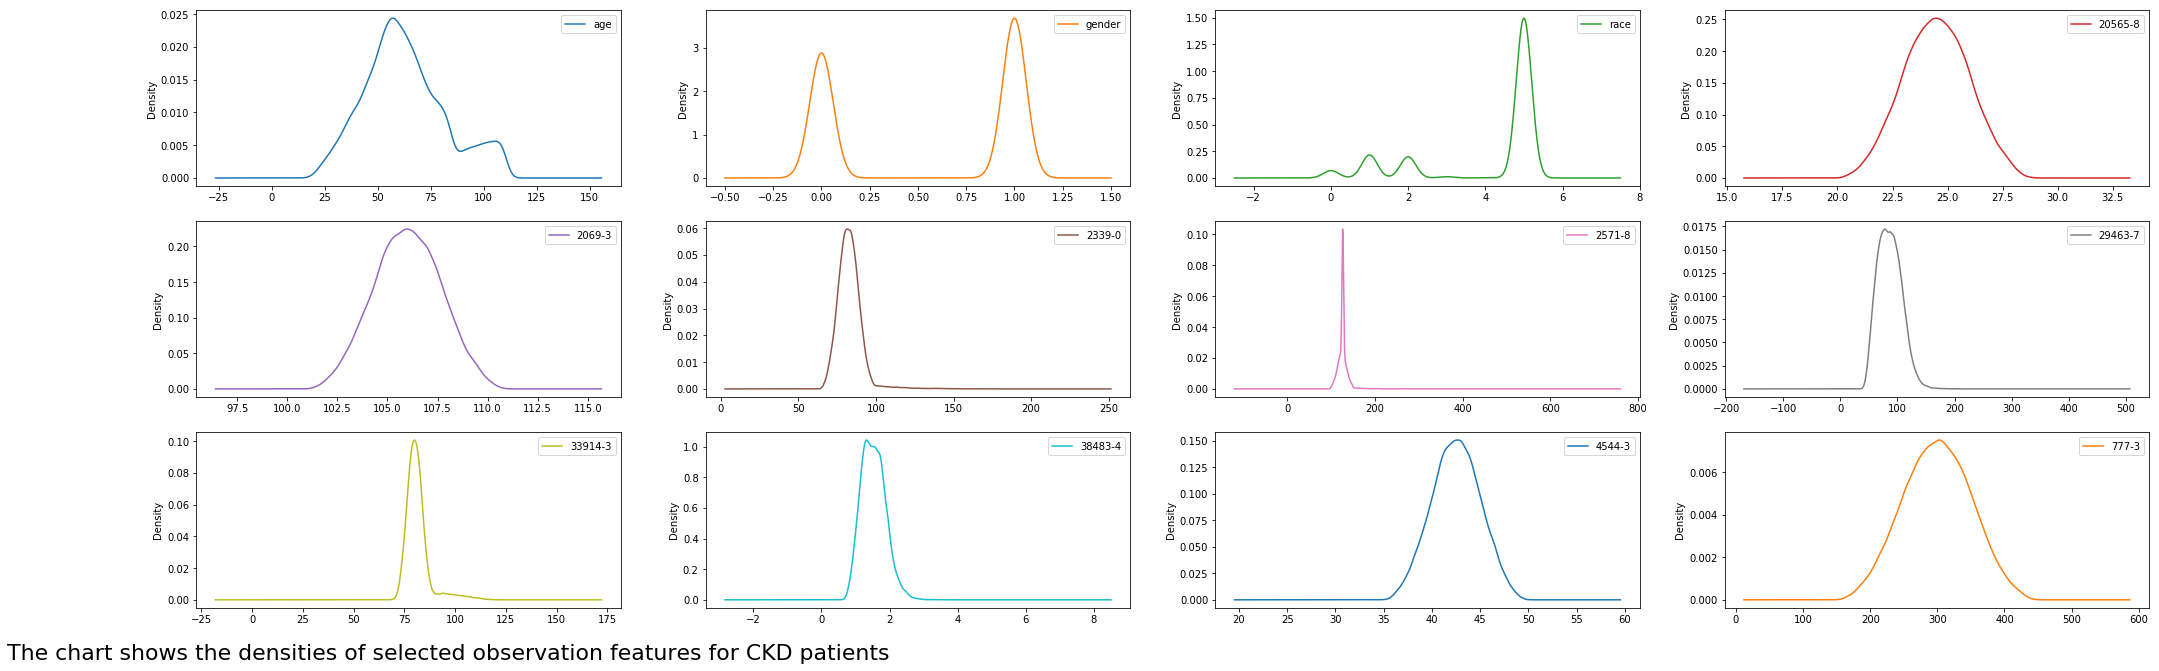

In [13]:
final_data1 = model_data[model_data['kdflag']==1][['age','gender','race','20565-8','2069-3','2339-0','2571-8','29463-7','33914-3','38483-4','4544-3','777-3']]
final_data1.plot(kind='density', subplots=True, layout=(3,4), sharex=False,figsize=(35,10))
plt.subplots_adjust(bottom=0.05)
text="The chart shows the densities of selected observation features for CKD patients"
plt.figtext(0.05,0.00, text, fontsize=22, va="top", ha="left")
plt.show()

<h4>Model Building</h4>

This function is to evaluate perfomance of algorithm on a base level. The outputs of this function are the model metrics

In [14]:
#Function to perform model fitting and prediction
def compare_model(trn_ft,tst_ft,trn_lbl,tst_lbl):
    from matplotlib.pyplot import figure
    modelname = []
    modelaccuracy = []
    model_roc_auc_score = []
    figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    train_features = trn_ft
    test_features = tst_ft
    train_labels = trn_lbl
    test_labels = tst_lbl  
        
    for model_name,select_model in model_list:
        fit_model = select_model.fit(train_features,train_labels)
        model_predict = fit_model.predict(test_features)
        probability_1 = select_model.predict_proba(test_features)[:,1]
        model_accuracy = round(accuracy_score(test_labels,model_predict),2)
        model_recall = round(recall_score(test_labels,model_predict),2)
        model_precision = round(precision_score(test_labels,model_predict),2)
        roc_auc_score_model = round(roc_auc_score(test_labels,probability_1),2)
        model_confu = confusion_matrix(test_labels,model_predict)    
        modelname.append(model_name)
        modelaccuracy.append(model_accuracy)
        model_roc_auc_score.append(roc_auc_score_model)
        test_labels_binary = label_binarize(test_labels, classes=[0,1]) 
        fpr, tpr, threshold = roc_curve(test_labels_binary, probability_1)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label = (model_name, round(roc_auc,2)))       
        plt.legend(loc='upper left') 
        print(model_name+' Acc: '+str(model_accuracy)+' AUC: '+str(roc_auc_score_model) +' Recall: '+str(model_recall)+' Precision: '+str(model_precision)+' FPR: '+str(round(((model_confu[0][1])/(model_confu[0][1]+model_confu[0][0])),2)) + ' TPR: '+str(round(((model_confu[1][1])/(model_confu[1][1]+model_confu[1][0])),2)))
        print ('TN , FP \nFN, TP')
        print (model_confu)
        if model_name=='LR':
            model_path = os.path.join(os.path.pardir,'Synthetic-Iteration5','lr.pkl')
            model_pickle = open(model_path,'wb')
            pickle.dump(fit_model,model_pickle)
            model_pickle.close()
    return model_predict

In [15]:
#Object creation for Models
lr = LogisticRegression(penalty='l2',C=10,class_weight='balanced')
rfc_model = RandomForestClassifier(n_estimators=1000, max_depth=50, max_features='auto', bootstrap=False, min_samples_leaf=1, min_samples_split=2)
xgb_model = XGBClassifier()
model_list = []
model_list.append(('LR',lr))
model_list.append(('RFC',rfc_model))
model_list.append(('XGB',xgb_model))

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LR Acc: 0.87 AUC: 0.94 Recall: 0.95 Precision: 0.45 FPR: 0.14 TPR: 0.95
TN , FP 
FN, TP
[[74925 12546]
 [  578 10358]]
RFC Acc: 0.93 AUC: 0.96 Recall: 0.6 Precision: 0.69 FPR: 0.03 TPR: 0.6
TN , FP 
FN, TP
[[84547  2924]
 [ 4373  6563]]
XGB Acc: 0.92 AUC: 0.96 Recall: 0.56 Precision: 0.7 FPR: 0.03 TPR: 0.56
TN , FP 
FN, TP
[[84852  2619]
 [ 4773  6163]]


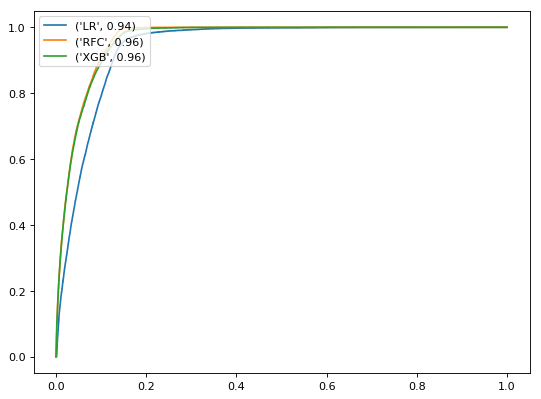

In [16]:
seed = 20

# Base Features
features = model_data.drop(['kdflag'],axis=1)
labels = model_data['kdflag']

# Split train and test features
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.3, random_state = seed)

# Plot the metrics for Baseline model
model_predict = compare_model(train_features,test_features,train_labels,test_labels)

<h4>Probability Prediction</h4>

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Number of patients having 90% probability of predicting having CKD:  8825
Number of patients having 90% probability of predicting doesn't having CKD:  64132
Number of patients having 95% probability of predicting having CKD:  3555
Number of patients having 95% probability of predicting doesn't having CKD:  54017
Number of patients having 99% probability of predicting having CKD:  231
Number of patients having 99% probability of predicting doesn't having CKD:  23932


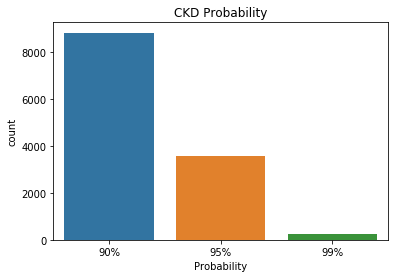

In [21]:
#Function to perform probability prediction
def probability_prediction(trn_ft,tst_ft,trn_lbl,tst_lbl):
    train_features = trn_ft
    test_features = tst_ft
    train_labels = trn_lbl
    test_labels = tst_lbl  
    fit_model = lr.fit(train_features,train_labels)
    model_predict = fit_model.predict(test_features)
    probability_1 = lr.predict_proba(test_features)[:,1]
    probability_0 = lr.predict_proba(test_features)[:,0]
    p1_gt90 = [p90 for p90 in probability_1 if p90 >= .9]
    p0_gt90 = [p90 for p90 in probability_0 if p90 >= .9]
    p1_gt95 = [p95 for p95 in probability_1 if p95 >= .95]
    p0_gt95 = [p95 for p95 in probability_0 if p95 >= .95]
    p1_gt99 = [p99 for p99 in probability_1 if p99 >= .99]
    p0_gt99 = [p99 for p99 in probability_0 if p99 >= .99]
    print("Number of patients having 90% probability of predicting having CKD: ", len(p1_gt90))
    print("Number of patients having 90% probability of predicting doesn't having CKD: ", len(p0_gt90))
    print("Number of patients having 95% probability of predicting having CKD: ", len(p1_gt95))
    print("Number of patients having 95% probability of predicting doesn't having CKD: ", len(p0_gt95))
    print("Number of patients having 99% probability of predicting having CKD: ", len(p1_gt99))
    print("Number of patients having 99% probability of predicting doesn't having CKD: ", len(p0_gt99))
    ckd_per = ['90%','95%','99%']
    ckd_val = [len(p1_gt90),len(p1_gt95),len(p1_gt99)]
    ckd_set = {'Probability':ckd_per,'count':ckd_val}
    ckd_df = pd.DataFrame(ckd_set)
    se.barplot(x=ckd_df['Probability'],y=ckd_df['count'])
    plt.title('CKD Probability')
        
probability_prediction(train_features,test_features,train_labels,test_labels)

# END